In [1]:
import os
import re
import sys
from pathlib import Path

import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import skimage
from skimage import io
from tqdm.notebook import tqdm, trange
import seaborn as sns
from matplotlib.colors import LogNorm
from matplotlib.patches import Patch

sc.settings.verbosity = 3


In [2]:
p_dir = (Path().cwd().parents[0]).absolute()
data_dir = p_dir / "data"

In [3]:
%load_ext autoreload
%autoreload 2

module_path = str(p_dir / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

import utils as my_utils

In [4]:
donors = [
    "LN Donor A",
    "LN Donor E",
    "INT Donor B",
    "INT Donor E",
    "TS Donor A",
    "TS Donor E",
]


In [5]:
from PIL import Image


# Read Data

In [6]:
# Plot clustered cell within each mask
import matplotlib 
from PIL import Image
from skimage import measure 

def create_clustered_cell(mask, label2cell, my_cmap, **kwargs):
    img = np.zeros((mask.shape[0], mask.shape[1],3), dtype=np.uint8)

    # for i, cells in tqdm(label2cell.items(), total=len(label2cell), leave=False):
    for i, cells in label2cell.items():
        rows, cols = np.where(np.isin(mask, cells))
        img[rows, cols, :] = my_cmap[int(i)]
    return img


def get_img_size(roi_dict, size=1000):
    row_max = 0
    col_max = 0
    for k, v in roi_dict.items():
        row_max = max(row_max, v[0])
        col_max = max(col_max, v[1])
    return row_max + size, col_max + size

# Read mask image
def get_masks(mask_folder):
    """
    Function to get all mask from mask forlder
    """
    # Read masks
    masks = {}

    for (dirpath, dirnames, filenames) in os.walk(mask_folder):
        for name in sorted(filenames):
            if "tif" in name:
                filename = os.path.join(dirpath, name)
                img = skimage.io.imread(filename)
                condition =  name.split(".")[0]
                masks[condition] = img
            else:
                continue
    return masks


In [7]:
# Format row, col
arrangement = {
    "LN Donor A": {
        1: [0, 1000],
        2: [0, 2000],
        3: [1000, 0],
        4: [1000, 1000],
        5: [1000, 2000],
        6: [1000, 3000],
        7: [2000, 0],
        8: [2000, 1000],
        9: [2000, 2000],
        10: [2000, 3000],
        11: [3000, 0],
        12: [3000, 1000],
        13: [3000, 2000],
        14: [3000, 3000],
        15: [4000, 1000],
        16: [4000, 2000],
    },
    "LN Donor E": {
        1: [1000, 0],
        2: [1000, 1000],
        3: [1000, 2000],
        4: [1000, 3000],
        5: [1000, 4000],
        6: [1000, 5000],
        7: [1000, 6000],
        8: [1000, 7000],
        9: [1000, 8000],
        10: [0, 0],
        11: [0, 1000],
        12: [0, 2000],
        13: [0, 3000],
        14: [0, 4000],
    },
    "INT Donor B": {
        1: [0, 0],
        2: [0, 1000],
        3: [1000, 0],
        4: [1000, 1000],
        5: [2000, 0],
        6: [2000, 1000],
        7: [2000, 2000],
        8: [2000, 3000],
        9: [3000, 0],
        10: [3000, 1000],
        11: [3000, 2000],
        12: [3000, 3000],
        13: [4000, 0],
        14: [4000, 1000],
        15: [4000, 2000],
        16: [4000, 3000],
        # 17: [5000, 0],
        # 18: [5000, 1000],
        # 19: [5000, 2000],
        # 20: [5000, 3000],
    },
    "INT Donor E": {
        1: [0, 0],
        2: [0, 1000],
        3: [0, 2000],
        4: [0, 3000],
        # 5: [0, 4000],
        6: [1000, 0],
        7: [1000, 1000],
        8: [1000, 2000],
        9: [1000, 3000],
        10: [1000, 4000],
        11: [2000, 3000],
        12: [2000, 4000],
        13: [3000, 3000],
        14: [3000, 4000],
        15: [4000, 3000],
        16: [4000, 4000],
    },
    "TS Donor A": {
        1: [0, 0],
        2: [0, 1000],
        3: [0, 2000],
        4: [0, 3000],
        5: [0, 4000],
        6: [0, 5000],
        7: [0, 6000],
        8: [1000, 0],
        9: [1000, 1000],
        10: [1000, 2000],
        11: [1000, 3000],
        12: [1000, 4000],
        13: [1000, 5000],
        14: [1000, 6000],
    },
    "TS Donor E": {
        1: [0, 0],
        2: [0, 1000],
        3: [0, 2000],
        4: [1000, 0],
        5: [1000, 1000],
        6: [1000, 2000],
        7: [2000, 0],
        8: [2000, 1000],
        9: [2000, 2000],
        10: [3000, 0],
        11: [3000, 1000],
        12: [3000, 2000],
        13: [4000, 0],
        14: [4000, 1000],
        15: [4000, 2000],
        16: [5000, 0],
        17: [5000, 1000],
        18: [5000, 2000],
    },
    "SP Donor A": {
        1: [0, 0],
        2: [0, 1000],
        3: [0, 2000],
        4: [0, 3000],
        5: [0, 4000],
        6: [1000, 0],
        7: [1000, 1000],
        8: [1000, 2000],
        9: [1000, 3000],
        10: [1000, 4000],
        11: [2000, 0],
        12: [2000, 1000],
        13: [2000, 2000],
        14: [2000, 3000],
        15: [2000, 4000],
        16: [3000, 0],
        17: [3000, 1000],
        18: [3000, 2000],
        19: [3000, 3000],
        20: [3000, 4000],
    },
}

In [8]:
# Read single-cell data
adata_path = data_dir / "metadata" / f"combined_semi_final.h5ad"
adata = sc.read_h5ad(adata_path)

rename_dict = {'Activated B':'B-cells',  'B-cells MZ':'B-cells', 'CD38+': 'Stroma', 
               'Stroma Vimentin+': 'Stroma'
              }

# Rename a cluster
adata.obs["cluster"] = adata.obs["Phenotype"].map(lambda x: rename_dict.get(x, x)).astype('category')


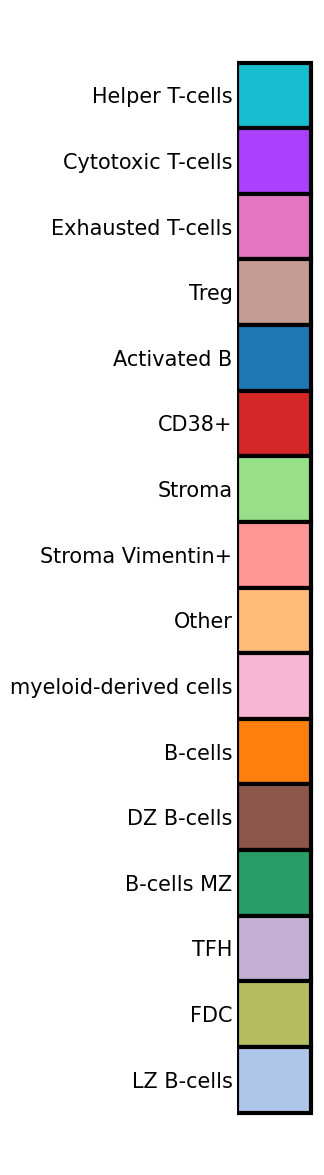

In [9]:
var = 'Phenotype'

cluster_label_order = adata.uns[f'dendrogram_{var}']['categories_ordered']

colors = adata.uns[f"{var}_colors"]
labels = adata.obs[var].cat.categories.tolist()

colors_rgb = []
for color in colors:
    colors_rgb.append(matplotlib.colors.hex2color(color))
colors_rgb = np.array(colors_rgb) * 255
colors_rgb = colors_rgb.astype(np.uint8)

colors_rgb_dict = {k:v for k,v in zip(labels, colors_rgb)}


c=np.array([colors_rgb_dict[i] for i in cluster_label_order])

# legend
fig, ax = plt.subplots(figsize=(1,15))
ax.barh(y=range(len(colors_rgb_dict.values())), 
        color=c/255,
        width=1, 
        height=1,
        edgecolor='k',
        linewidth=3,
       )
_ = plt.yticks(range(len(colors_rgb_dict.values())), cluster_label_order, rotation=0, size=15)
_ = plt.xticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis=u'both', which=u'both',length=0)
# ax.yaxis.tick_right()
ax.invert_yaxis()
ax.grid(False)


In [10]:
# Get adata 
phenotype_name = 'cluster'

sc.tl.dendrogram(adata, groupby=phenotype_name)

adata.uns["New_colors"] = sc.pl.palettes.vega_20_scanpy[:len(np.unique(adata.obs[phenotype_name]))]
cluster_label_order = adata.uns[f'dendrogram_{phenotype_name}']['categories_ordered']

# Define colormap
colors = adata.uns["New_colors"]
labels = adata.obs[phenotype_name].cat.categories.tolist()

colors_rgb = []
for color in colors:
    colors_rgb.append(matplotlib.colors.hex2color(color))
colors_rgb = np.array(colors_rgb) * 255
colors_rgb = colors_rgb.astype(np.uint8)
colors_rgb_dict = {k:v for k,v in zip(labels, colors_rgb)}

    using data matrix X directly
Storing dendrogram info using `.uns['dendrogram_cluster']`


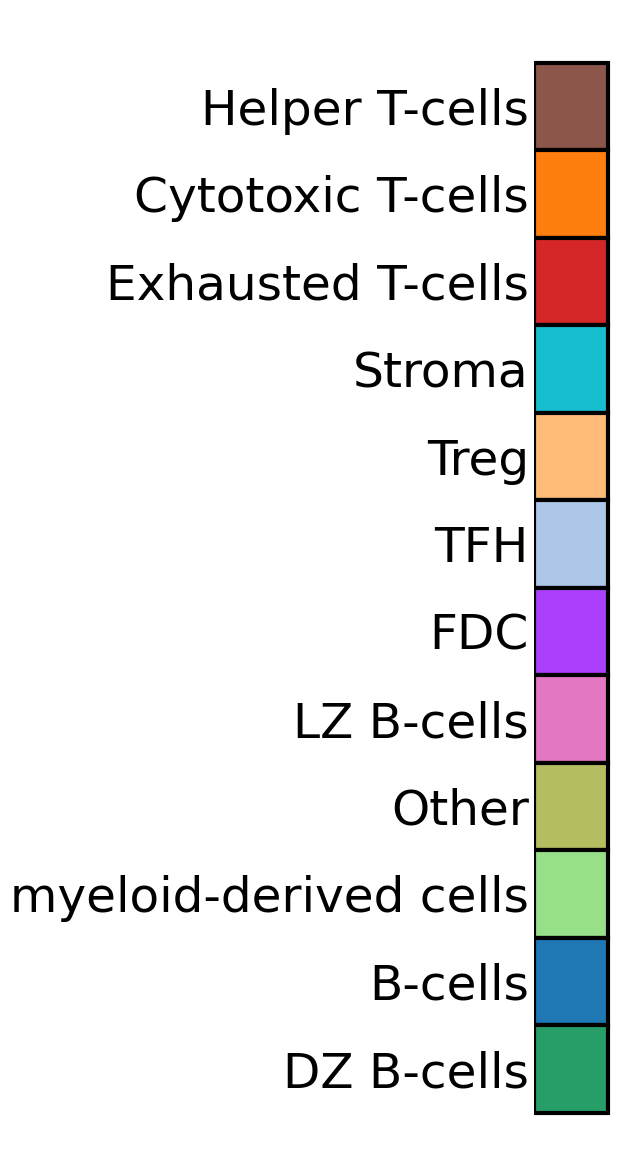

In [11]:
c=np.array([colors_rgb_dict[i] for i in cluster_label_order])

# legend
fig, ax = plt.subplots(figsize=(1,15))
ax.barh(y=range(len(colors_rgb_dict.values())), 
        color=c/255,
        width=1, 
        height=1,
        edgecolor='k',
        linewidth=3,
       )
_ = plt.yticks(range(len(colors_rgb_dict.values())), cluster_label_order, rotation=0, size=35)
_ = plt.xticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis=u'both', which=u'both',length=0)
# ax.yaxis.tick_right()
ax.invert_yaxis()
ax.grid(False)


In [12]:
colors_rgb_gray = np.append(colors_rgb, np.array([[72,72,72]]),axis=0)
gray_indice = len(colors_rgb_gray) - 1

## LN

In [94]:
size = 1000 

DATA = 'LN'

for donor in donors:
    if DATA not in donor:
        continue
        
    adata_donor = adata[adata.obs.Dataset == donor, :]
    masks = get_masks(data_dir / "masks" / donor)

    # Create combined images
    y_max, x_max = get_img_size(arrangement[donor])
    
    
    img_combined = np.zeros((y_max, x_max, 3), dtype=np.uint8)

    for i in adata_donor.obs.ROI.unique():
        if i not in arrangement[donor].keys():
            continue

        # Get dataset
        adata_s = adata_donor[adata_donor.obs.ROI == i, :]
        mask = masks[str(int(i))]

        # Get label2cell dict
        label2cell = {}
        for j, l in enumerate(labels):
            cell_id = adata_s[adata_s.obs[phenotype_name] == l].obs.Cell.to_list()
            label2cell[j] = cell_id

        img = create_clustered_cell(mask, label2cell, colors_rgb)

        # Insert to combine image
        y = max(0, arrangement[donor][i][0] - 1)
        x = max(0, arrangement[donor][i][1] - 1)
        img_combined[y : y + size, x : x + size] = img

    save_path = p_dir / "figures" / "pairwise" / f"{donor}_all.png"
    img_combined = Image.fromarray(img_combined)
    img_combined.save(save_path)


In [95]:
size = 1000 

cluster_list = [['Cytotoxic T-cells', 'Helper T-cells'], ['Stroma', 'FDC'],
               ['Stroma', 'DZ B-cells'], ['TFH', 'LZ B-cells']]

for donor in donors:
    if DATA not in donor:
        continue
        
    adata_donor = adata[adata.obs.Dataset == donor, :]
    masks = get_masks(data_dir / "masks" / donor)

    # Create combined images
    y_max, x_max = get_img_size(arrangement[donor])
    
    for markers in cluster_list:
        img_combined = np.zeros((y_max, x_max, 3), dtype=np.uint8)

        for i in adata_donor.obs.ROI.unique():
            if i not in arrangement[donor].keys():
                continue

            # Get dataset
            adata_s = adata_donor[adata_donor.obs.ROI == i, :]
            mask = masks[str(int(i))]

            # Get label2cell dict
            label2cell = {}
            for j, l in enumerate(labels):
                cell_id = adata_s[adata_s.obs[phenotype_name] == l].obs.Cell.to_list()
                if l in markers:
                    label2cell[j] = cell_id
                else:
                    if gray_indice not in label2cell.keys():
                        label2cell[gray_indice] = cell_id
                    else:
                        label2cell[gray_indice] += cell_id
            img = create_clustered_cell(mask, label2cell, colors_rgb_gray)

            # Insert to combine image
            y = max(0, arrangement[donor][i][0] - 1)
            x = max(0, arrangement[donor][i][1] - 1)
            img_combined[y : y + size, x : x + size] = img

        save_path = p_dir / "figures" / "pairwise" / f"{donor}_{markers[0]}-{markers[1]}.png"
        img_combined = Image.fromarray(img_combined)
        img_combined.save(save_path)



## INT

In [96]:
size = 1000 

DATA = 'INT'

for donor in donors:
    if DATA not in donor:
        continue
        
    adata_donor = adata[adata.obs.Dataset == donor, :]
    masks = get_masks(data_dir / "masks" / donor)

    # Create combined images
    y_max, x_max = get_img_size(arrangement[donor])
    
    
    img_combined = np.zeros((y_max, x_max, 3), dtype=np.uint8)

    for i in adata_donor.obs.ROI.unique():
        if i not in arrangement[donor].keys():
            continue

        # Get dataset
        adata_s = adata_donor[adata_donor.obs.ROI == i, :]
        mask = masks[str(int(i))]

        # Get label2cell dict
        label2cell = {}
        for j, l in enumerate(labels):
            cell_id = adata_s[adata_s.obs[phenotype_name] == l].obs.Cell.to_list()
            label2cell[j] = cell_id

        img = create_clustered_cell(mask, label2cell, colors_rgb)

        # Insert to combine image
        y = max(0, arrangement[donor][i][0] - 1)
        x = max(0, arrangement[donor][i][1] - 1)
        img_combined[y : y + size, x : x + size] = img

    save_path = p_dir / "figures" / "pairwise" / f"{donor}_all.png"
    img_combined = Image.fromarray(img_combined)
    img_combined.save(save_path)


In [97]:
size = 1000 

cluster_list = [['FDC', 'Cytotoxic T-cells'], ['FDC', 'Treg'], ['DZ B-cells', 'Stroma'], ['FDC','TFH']]

for donor in donors:
    if DATA not in donor:
        continue
        
    adata_donor = adata[adata.obs.Dataset == donor, :]
    masks = get_masks(data_dir / "masks" / donor)

    # Create combined images
    y_max, x_max = get_img_size(arrangement[donor])
    
    for markers in cluster_list:
        img_combined = np.zeros((y_max, x_max, 3), dtype=np.uint8)

        for i in adata_donor.obs.ROI.unique():
            if i not in arrangement[donor].keys():
                continue

            # Get dataset
            adata_s = adata_donor[adata_donor.obs.ROI == i, :]
            mask = masks[str(int(i))]

            # Get label2cell dict
            label2cell = {}
            for j, l in enumerate(labels):
                cell_id = adata_s[adata_s.obs[phenotype_name] == l].obs.Cell.to_list()
                if l in markers:
                    label2cell[j] = cell_id
                else:
                    if gray_indice not in label2cell.keys():
                        label2cell[gray_indice] = cell_id
                    else:
                        label2cell[gray_indice] += cell_id
            img = create_clustered_cell(mask, label2cell, colors_rgb_gray)

            # Insert to combine image
            y = max(0, arrangement[donor][i][0] - 1)
            x = max(0, arrangement[donor][i][1] - 1)
            img_combined[y : y + size, x : x + size] = img

        save_path = p_dir / "figures" / "pairwise" / f"{donor}_{markers[0]}-{markers[1]}.png"
        img_combined = Image.fromarray(img_combined)
        img_combined.save(save_path)



## TS

In [13]:
size = 1000 

DATA = 'TS'

for donor in donors:
    if DATA not in donor:
        continue
        
    adata_donor = adata[adata.obs.Dataset == donor, :]
    masks = get_masks(data_dir / "masks" / donor)

    # Create combined images
    y_max, x_max = get_img_size(arrangement[donor])
    
    
    img_combined = np.zeros((y_max, x_max, 3), dtype=np.uint8)

    for i in adata_donor.obs.ROI.unique():
        if i not in arrangement[donor].keys():
            continue

        # Get dataset
        adata_s = adata_donor[adata_donor.obs.ROI == i, :]
        mask = masks[str(int(i))]

        # Get label2cell dict
        label2cell = {}
        for j, l in enumerate(labels):
            cell_id = adata_s[adata_s.obs[phenotype_name] == l].obs.Cell.to_list()
            label2cell[j] = cell_id

        img = create_clustered_cell(mask, label2cell, colors_rgb)

        # Insert to combine image
        y = max(0, arrangement[donor][i][0] - 1)
        x = max(0, arrangement[donor][i][1] - 1)
        img_combined[y : y + size, x : x + size] = img

    save_path = p_dir / "figures" / "pairwise" / f"{donor}_all.png"
    img_combined = Image.fromarray(img_combined)
    img_combined.save(save_path)


In [99]:
size = 1000 

cluster_list = [['FDC', 'TFH'], ['Cytotoxic T-cells', 'Helper T-cells'], ['Stroma', ]]

for donor in donors:
    if DATA not in donor:
        continue
        
    adata_donor = adata[adata.obs.Dataset == donor, :]
    masks = get_masks(data_dir / "masks" / donor)

    # Create combined images
    y_max, x_max = get_img_size(arrangement[donor])
    
    for markers in cluster_list:
        img_combined = np.zeros((y_max, x_max, 3), dtype=np.uint8)

        for i in adata_donor.obs.ROI.unique():
            if i not in arrangement[donor].keys():
                continue

            # Get dataset
            adata_s = adata_donor[adata_donor.obs.ROI == i, :]
            mask = masks[str(int(i))]

            # Get label2cell dict
            label2cell = {}
            for j, l in enumerate(labels):
                cell_id = adata_s[adata_s.obs[phenotype_name] == l].obs.Cell.to_list()
                if l in markers:
                    label2cell[j] = cell_id
                else:
                    if gray_indice not in label2cell.keys():
                        label2cell[gray_indice] = cell_id
                    else:
                        label2cell[gray_indice] += cell_id
            img = create_clustered_cell(mask, label2cell, colors_rgb_gray)

            # Insert to combine image
            y = max(0, arrangement[donor][i][0] - 1)
            x = max(0, arrangement[donor][i][1] - 1)
            img_combined[y : y + size, x : x + size] = img

        save_path = p_dir / "figures" / "pairwise" / f"{donor}_{markers[0]}-{markers[1]}.png"
        img_combined = Image.fromarray(img_combined)
        img_combined.save(save_path)



# Manual

In [17]:
# Read single-cell data
adata_path = data_dir / "metadata" / f"combined_flowjo.h5ad"
adata = sc.read_h5ad(adata_path)

rename_dict = {'Activated B':'B-cells',  'B-cells MZ':'B-cells', 'CD38+': 'Stroma', 
               'Stroma Vimentin+': 'Stroma'
              }

# Rename a cluster
adata.obs["cluster"] = adata.obs["Phenotype"].map(lambda x: rename_dict.get(x, x)).astype('category')

C:\Users\thu71\Anaconda3\envs\traj\lib\site-packages\anndata\_core\anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [18]:
adata.obs.columns = ['Donor', 'Phenotype', 'ROI', 'Cell', 'index', 'Dataset',
       'cluster']

In [19]:
# Get adata 
phenotype_name = 'cluster'

sc.tl.dendrogram(adata, groupby=phenotype_name)

adata.uns["New_colors"] = sc.pl.palettes.vega_20_scanpy[:len(np.unique(adata.obs[phenotype_name]))]
cluster_label_order = adata.uns[f'dendrogram_{phenotype_name}']['categories_ordered']

# Define colormap
colors = adata.uns["New_colors"]
labels = adata.obs[phenotype_name].cat.categories.tolist()

colors_rgb = []
for color in colors:
    colors_rgb.append(matplotlib.colors.hex2color(color))
colors_rgb = np.array(colors_rgb) * 255
colors_rgb = colors_rgb.astype(np.uint8)
colors_rgb_dict = {k:v for k,v in zip(labels, colors_rgb)}

    using data matrix X directly
Storing dendrogram info using `.uns['dendrogram_cluster']`


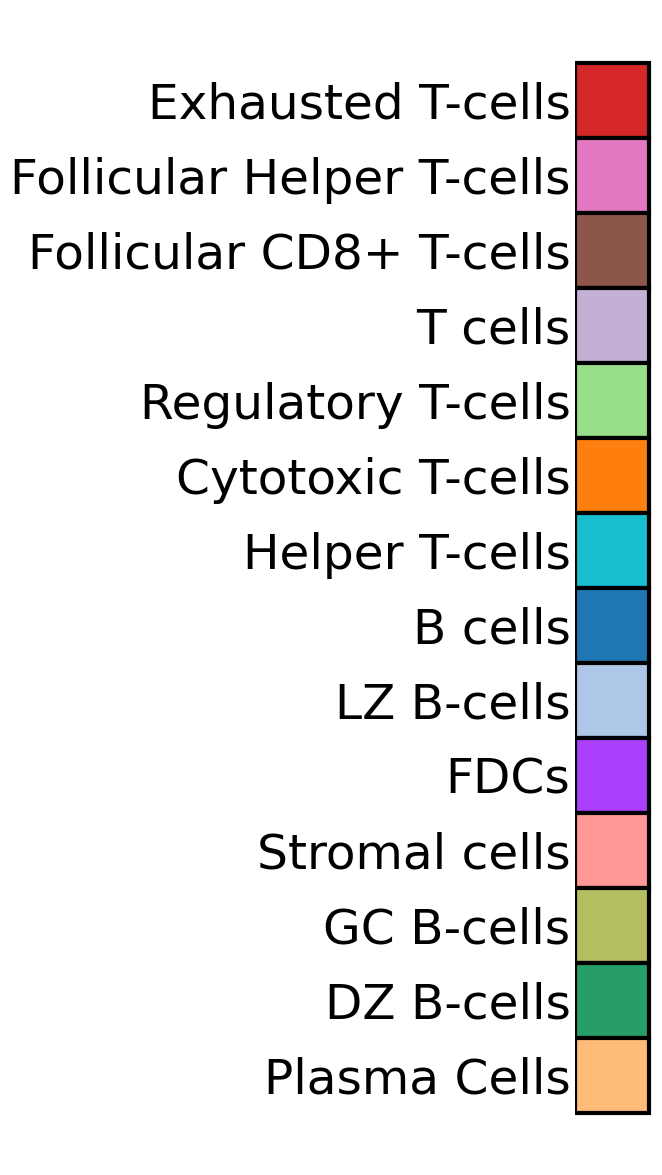

In [20]:
c=np.array([colors_rgb_dict[i] for i in cluster_label_order])

# legend
fig, ax = plt.subplots(figsize=(1,15))
ax.barh(y=range(len(colors_rgb_dict.values())), 
        color=c/255,
        width=1, 
        height=1,
        edgecolor='k',
        linewidth=3,
       )
_ = plt.yticks(range(len(colors_rgb_dict.values())), cluster_label_order, rotation=0, size=35)
_ = plt.xticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis=u'both', which=u'both',length=0)
# ax.yaxis.tick_right()
ax.invert_yaxis()
ax.grid(False)


In [21]:
colors_rgb_gray = np.append(colors_rgb, np.array([[72,72,72]]),axis=0)
gray_indice = len(colors_rgb_gray) - 1

## LN

In [105]:
size = 1000 

DATA = 'LN'

for donor in donors:
    if DATA not in donor:
        continue
        
    adata_donor = adata[adata.obs.Dataset == donor, :]
    masks = get_masks(data_dir / "masks" / donor)

    # Create combined images
    y_max, x_max = get_img_size(arrangement[donor])
    
    
    img_combined = np.zeros((y_max, x_max, 3), dtype=np.uint8)

    for i in adata_donor.obs.ROI.unique():
        if i not in arrangement[donor].keys():
            continue

        # Get dataset
        adata_s = adata_donor[adata_donor.obs.ROI == i, :]
        mask = masks[str(int(i))]

        # Get label2cell dict
        label2cell = {}
        for j, l in enumerate(labels):
            cell_id = adata_s[adata_s.obs[phenotype_name] == l].obs.Cell.to_list()
            label2cell[j] = cell_id

        img = create_clustered_cell(mask, label2cell, colors_rgb)

        # Insert to combine image
        y = max(0, arrangement[donor][i][0] - 1)
        x = max(0, arrangement[donor][i][1] - 1)
        img_combined[y : y + size, x : x + size] = img

    save_path = p_dir / "figures" / "pairwise" / f"{donor}_all.png"
    img_combined = Image.fromarray(img_combined)
    img_combined.save(save_path)


In [106]:
size = 1000 

cluster_list = [['Stromal cells', 'FDCs'],['Stromal cells', 'Plasma Cells']]

for donor in donors:
    if DATA not in donor:
        continue
        
    adata_donor = adata[adata.obs.Dataset == donor, :]
    masks = get_masks(data_dir / "masks" / donor)

    # Create combined images
    y_max, x_max = get_img_size(arrangement[donor])
    
    for markers in cluster_list:
        img_combined = np.zeros((y_max, x_max, 3), dtype=np.uint8)

        for i in adata_donor.obs.ROI.unique():
            if i not in arrangement[donor].keys():
                continue

            # Get dataset
            adata_s = adata_donor[adata_donor.obs.ROI == i, :]
            mask = masks[str(int(i))]

            # Get label2cell dict
            label2cell = {}
            for j, l in enumerate(labels):
                cell_id = adata_s[adata_s.obs[phenotype_name] == l].obs.Cell.to_list()
                if l in markers:
                    label2cell[j] = cell_id
                else:
                    if gray_indice not in label2cell.keys():
                        label2cell[gray_indice] = cell_id
                    else:
                        label2cell[gray_indice] += cell_id

            img = create_clustered_cell(mask, label2cell, colors_rgb_gray)

            # Insert to combine image
            y = max(0, arrangement[donor][i][0] - 1)
            x = max(0, arrangement[donor][i][1] - 1)
            img_combined[y : y + size, x : x + size] = img

        save_path = p_dir / "figures" / "pairwise" / f"{donor}_{markers[0]}-{markers[1]}.png"
        img_combined = Image.fromarray(img_combined)
        img_combined.save(save_path)



## INT

In [107]:
size = 1000 

DATA = 'INT'

for donor in donors:
    if DATA not in donor:
        continue
        
    adata_donor = adata[adata.obs.Dataset == donor, :]
    masks = get_masks(data_dir / "masks" / donor)

    # Create combined images
    y_max, x_max = get_img_size(arrangement[donor])
    
    
    img_combined = np.zeros((y_max, x_max, 3), dtype=np.uint8)

    for i in adata_donor.obs.ROI.unique():
        if i not in arrangement[donor].keys():
            continue

        # Get dataset
        adata_s = adata_donor[adata_donor.obs.ROI == i, :]
        mask = masks[str(int(i))]

        # Get label2cell dict
        label2cell = {}
        for j, l in enumerate(labels):
            cell_id = adata_s[adata_s.obs[phenotype_name] == l].obs.Cell.to_list()
            label2cell[j] = cell_id

        img = create_clustered_cell(mask, label2cell, colors_rgb)

        # Insert to combine image
        y = max(0, arrangement[donor][i][0] - 1)
        x = max(0, arrangement[donor][i][1] - 1)
        img_combined[y : y + size, x : x + size] = img

    save_path = p_dir / "figures" / "pairwise" / f"{donor}_all.png"
    img_combined = Image.fromarray(img_combined)
    img_combined.save(save_path)


In [108]:
size = 1000 

cluster_list = [['Cytotoxic T-cells', 'Helper T-cells'], ['Stromal cells', 'FDCs'],  ['Stromal cells', 'Plasma Cells']]

for donor in donors:
    if DATA not in donor:
        continue
        
    adata_donor = adata[adata.obs.Dataset == donor, :]
    masks = get_masks(data_dir / "masks" / donor)

    # Create combined images
    y_max, x_max = get_img_size(arrangement[donor])
    
    for markers in cluster_list:
        img_combined = np.zeros((y_max, x_max, 3), dtype=np.uint8)

        for i in adata_donor.obs.ROI.unique():
            if i not in arrangement[donor].keys():
                continue

            # Get dataset
            adata_s = adata_donor[adata_donor.obs.ROI == i, :]
            mask = masks[str(int(i))]

            # Get label2cell dict
            label2cell = {}
            for j, l in enumerate(labels):
                cell_id = adata_s[adata_s.obs[phenotype_name] == l].obs.Cell.to_list()
                if l in markers:
                    label2cell[j] = cell_id
                else:
                    if gray_indice not in label2cell.keys():
                        label2cell[gray_indice] = cell_id
                    else:
                        label2cell[gray_indice] += cell_id
                    
            img = create_clustered_cell(mask, label2cell, colors_rgb_gray)

            # Insert to combine image
            y = max(0, arrangement[donor][i][0] - 1)
            x = max(0, arrangement[donor][i][1] - 1)
            img_combined[y : y + size, x : x + size] = img

        save_path = p_dir / "figures" / "pairwise" / f"{donor}_{markers[0]}-{markers[1]}.png"
        img_combined = Image.fromarray(img_combined)
        img_combined.save(save_path)



## TS

In [22]:
size = 1000 

DATA = 'TS'

for donor in donors:
    if DATA not in donor:
        continue
        
    adata_donor = adata[adata.obs.Dataset == donor, :]
    masks = get_masks(data_dir / "masks" / donor)

    # Create combined images
    y_max, x_max = get_img_size(arrangement[donor])
    
    
    img_combined = np.zeros((y_max, x_max, 3), dtype=np.uint8)

    for i in adata_donor.obs.ROI.unique():
        if i not in arrangement[donor].keys():
            continue

        # Get dataset
        adata_s = adata_donor[adata_donor.obs.ROI == i, :]
        mask = masks[str(int(i))]

        # Get label2cell dict
        label2cell = {}
        for j, l in enumerate(labels):
            cell_id = adata_s[adata_s.obs[phenotype_name] == l].obs.Cell.to_list()
            label2cell[j] = cell_id

        img = create_clustered_cell(mask, label2cell, colors_rgb)

        # Insert to combine image
        y = max(0, arrangement[donor][i][0] - 1)
        x = max(0, arrangement[donor][i][1] - 1)
        img_combined[y : y + size, x : x + size] = img

    save_path = p_dir / "figures" / "pairwise" / f"{donor}_all.png"
    img_combined = Image.fromarray(img_combined)
    img_combined.save(save_path)


In [23]:
print(list(adata.obs.cluster.unique()))

['Stromal cells', 'B cells', 'GC B-cells', 'DZ B-cells', 'LZ B-cells', 'Plasma Cells', 'FDCs', 'T cells', 'Cytotoxic T-cells', 'Exhausted T-cells', 'Follicular CD8+ T-cells', 'Helper T-cells', 'Follicular Helper T-cells', 'Regulatory T-cells']


In [25]:
size = 1000 

cluster_list = [['Stromal cells', 'FDCs'], ['Plasma Cells', 'FDCs'], ['Helper T-cells', 'FDCs'], ['Plasma Cells','DZ B-cells'],
               ['Plasma Cells','Stromal cells'], ['Plasma Cells','GC B-cells']]

for donor in donors:
    if DATA not in donor:
        continue
        
    adata_donor = adata[adata.obs.Dataset == donor, :]
    masks = get_masks(data_dir / "masks" / donor)

    # Create combined images
    y_max, x_max = get_img_size(arrangement[donor])
    
    for markers in cluster_list:
        img_combined = np.zeros((y_max, x_max, 3), dtype=np.uint8)

        for i in adata_donor.obs.ROI.unique():
            if i not in arrangement[donor].keys():
                continue

            # Get dataset
            adata_s = adata_donor[adata_donor.obs.ROI == i, :]
            mask = masks[str(int(i))]

            # Get label2cell dict
            label2cell = {}
            for j, l in enumerate(labels):
                cell_id = adata_s[adata_s.obs[phenotype_name] == l].obs.Cell.to_list()
                if l in markers:
                    label2cell[j] = cell_id
                else:
                    if gray_indice not in label2cell.keys():
                        label2cell[gray_indice] = cell_id
                    else:
                        label2cell[gray_indice] += cell_id
            img = create_clustered_cell(mask, label2cell, colors_rgb_gray)

            # Insert to combine image
            y = max(0, arrangement[donor][i][0] - 1)
            x = max(0, arrangement[donor][i][1] - 1)
            img_combined[y : y + size, x : x + size] = img

        save_path = p_dir / "figures" / "pairwise" / f"{donor}_{markers[0]}-{markers[1]}.png"
        img_combined = Image.fromarray(img_combined)
        img_combined.save(save_path)

